In [88]:
### To do
# Join the pipeline with Bboxes from Yolo properly (done)
# Ensure name and classes are transferred too (done)
# Resizing of the segmented masks will have to be done
# Depending on the number of annotation points, some might have to be discarded to ensure ease of reannotation
# color correction of image when being processed at different steps and being saved
# why are some masks getting truncated when being saved to json format

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd {HOME}

import sys
from IPython import display
display.clear_output()

# sam
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# ultralytics
!pip install ultralytics==8.0.20

# other installations
!pip install -q roboflow dataclasses-json supervision

In [4]:
import ultralytics
from ultralytics import YOLO
from IPython.display import display, Image
import torch


ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


### YOLO

In [5]:
## create space for yolo model

%cd {HOME}
!mkdir {HOME}/yolo_model
%cd {HOME}/yolo_model

/content
/content/yolo_model


In [6]:
## load yolo model dataset
%cd {HOME}

from roboflow import Roboflow
rf = Roboflow(api_key="ask-ishan")
project = rf.workspace("ishan-nangia-v1cd3").project("coral-detection-ci")
dataset = project.version(2).download("yolov8")

/content
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.20, to fix: `pip install ultralytics==8.0.134`


Extracting Dataset Version Zip to Coral-Detection-CI-2 in yolov8:: 100%|██████████| 271/271 [00:00<00:00, 808.56it/s]


In [9]:
# create yolo model and infer an image
img_name = "20230106_130848_jpg.rf.0406748ab411cfd7120bdbc8e70c5578.jpg"
img_address = f"/content/Coral-Detection-CI-2/valid/images/{img_name}"

model = YOLO(f'{HOME}/yolo_model/yolo_model.pt')

# Perform object detection on an image using the model
results = model(img_address)

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


In [10]:
# class: 1 = ref, 0 = coral
results[0].boxes.cls

tensor([1., 0., 0., 0., 0., 0.], device='cuda:0')

### SAM

In [11]:
# loading sam
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

/content
/content/weights
/content/weights/sam_vit_h_4b8939.pth ; exist: True


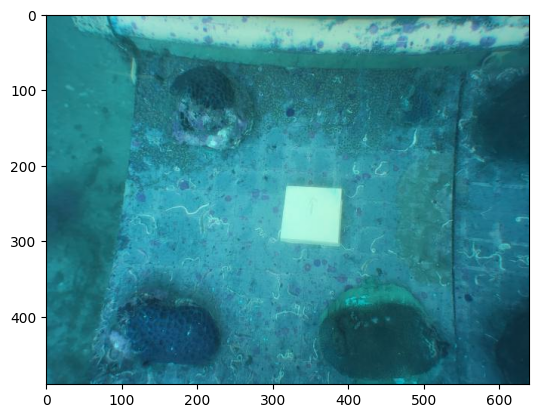

In [13]:
# load single image

import cv2
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np

image_bgr = cv2.imread(img_address)
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# resized_image = cv2.resize(image_rgb, (640, 490))
resized_image = image_bgr

plt.imshow(resized_image)

In [77]:
# multiple bounding boxes as input for a single image
input_boxes = results[0].boxes.xyxy
class_ids = results[0].boxes.cls.cpu().numpy()

mask_predictor = SamPredictor(sam)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(input_boxes, resized_image.shape[:2])
mask_predictor.set_image(resized_image)
masks, iou_predictions, low_res_masks = mask_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False
)

### Results visualisation with Supervision

In [78]:
# creating Detections object for all the masks

xyxys = np.array([sv.mask_to_xyxy(masks=i.cpu()) for i in masks])
xyxys = xyxys.squeeze(1)
numpy_masks = masks.cpu().numpy().squeeze(1)
detections = sv.Detections(
      class_id = class_ids,
      xyxy=xyxys,
      mask=numpy_masks
)

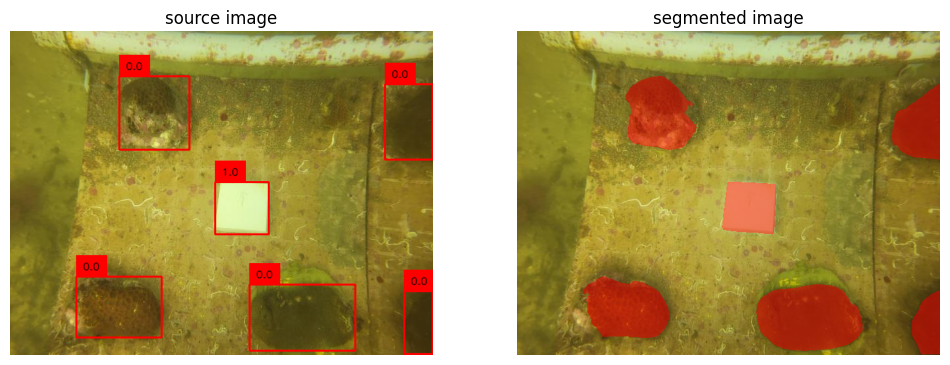

In [82]:
# bounding boxes and segmented areas

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
source_image = resized_image.copy()
segmented_image = resized_image.copy()

source_image = box_annotator.annotate(scene=source_image,
                                      detections=detections,
                                      skip_label=False)
segmented_image = mask_annotator.annotate(scene=segmented_image,
                                          detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [83]:
sample_dataset = sv.DetectionDataset(["coral", 'ref'],
                                     {"sample_image.jpeg": resized_image},
                                     {"sample_image.jpeg": detections})

In [84]:
sample_dataset.as_coco(annotations_path="./coco_sample.json")

In [85]:
cv2.imwrite("sample_image.jpeg", resized_image)

True